In [2]:
!pip install autogluon 

  Using cached autogluon-0.3.1-py3-none-any.whl (9.9 kB)
  Using cached autogluon.tabular-0.3.1-py3-none-any.whl (273 kB)
  Using cached autogluon.vision-0.3.1-py3-none-any.whl (38 kB)
  Using cached autogluon.features-0.3.1-py3-none-any.whl (56 kB)
  Using cached autogluon.mxnet-0.3.1-py3-none-any.whl (33 kB)
  Using cached autogluon.text-0.3.1-py3-none-any.whl (52 kB)
  Using cached autogluon.core-0.3.1-py3-none-any.whl (352 kB)
  Using cached autogluon.extra-0.3.1-py3-none-any.whl (28 kB)
  Using cached autograd-1.3.tar.gz (38 kB)
  Preparing metadata (setup.py) ... done
  Using cached scipy-1.6.3-cp37-cp37m-manylinux1_x86_64.whl (27.4 MB)
  Using cached distributed-2021.12.0-py3-none-any.whl (802 kB)
  Using cached dask-2021.12.0-py3-none-any.whl (1.0 MB)
  Using cached scikit_learn-0.24.2-cp37-cp37m-manylinux2010_x86_64.whl (22.3 MB)
  Using cached ConfigSpace-0.4.19-cp37-cp37m-manylinux2014_x86_64.whl (4.2 MB)
  Using cached openml-0.12.2.tar.gz (119 kB)
  Preparing metadata (set

In [3]:
%matplotlib inline
import autogluon.core as ag
from autogluon.vision import ImageDataset, ImagePredictor
import pandas as pd

/usr/local/lib/python3.7/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.8.0` and `torch==1.10.1+cu102` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [4]:
dataset = ImageDataset.from_folder('data/validation/')
dataset.head()

,image,label
0,/root/SageMaker-Inventory-monitoring/data/vali...,0
1,/root/SageMaker-Inventory-monitoring/data/vali...,0
2,/root/SageMaker-Inventory-monitoring/data/vali...,0
3,/root/SageMaker-Inventory-monitoring/data/vali...,0
4,/root/SageMaker-Inventory-monitoring/data/vali...,0


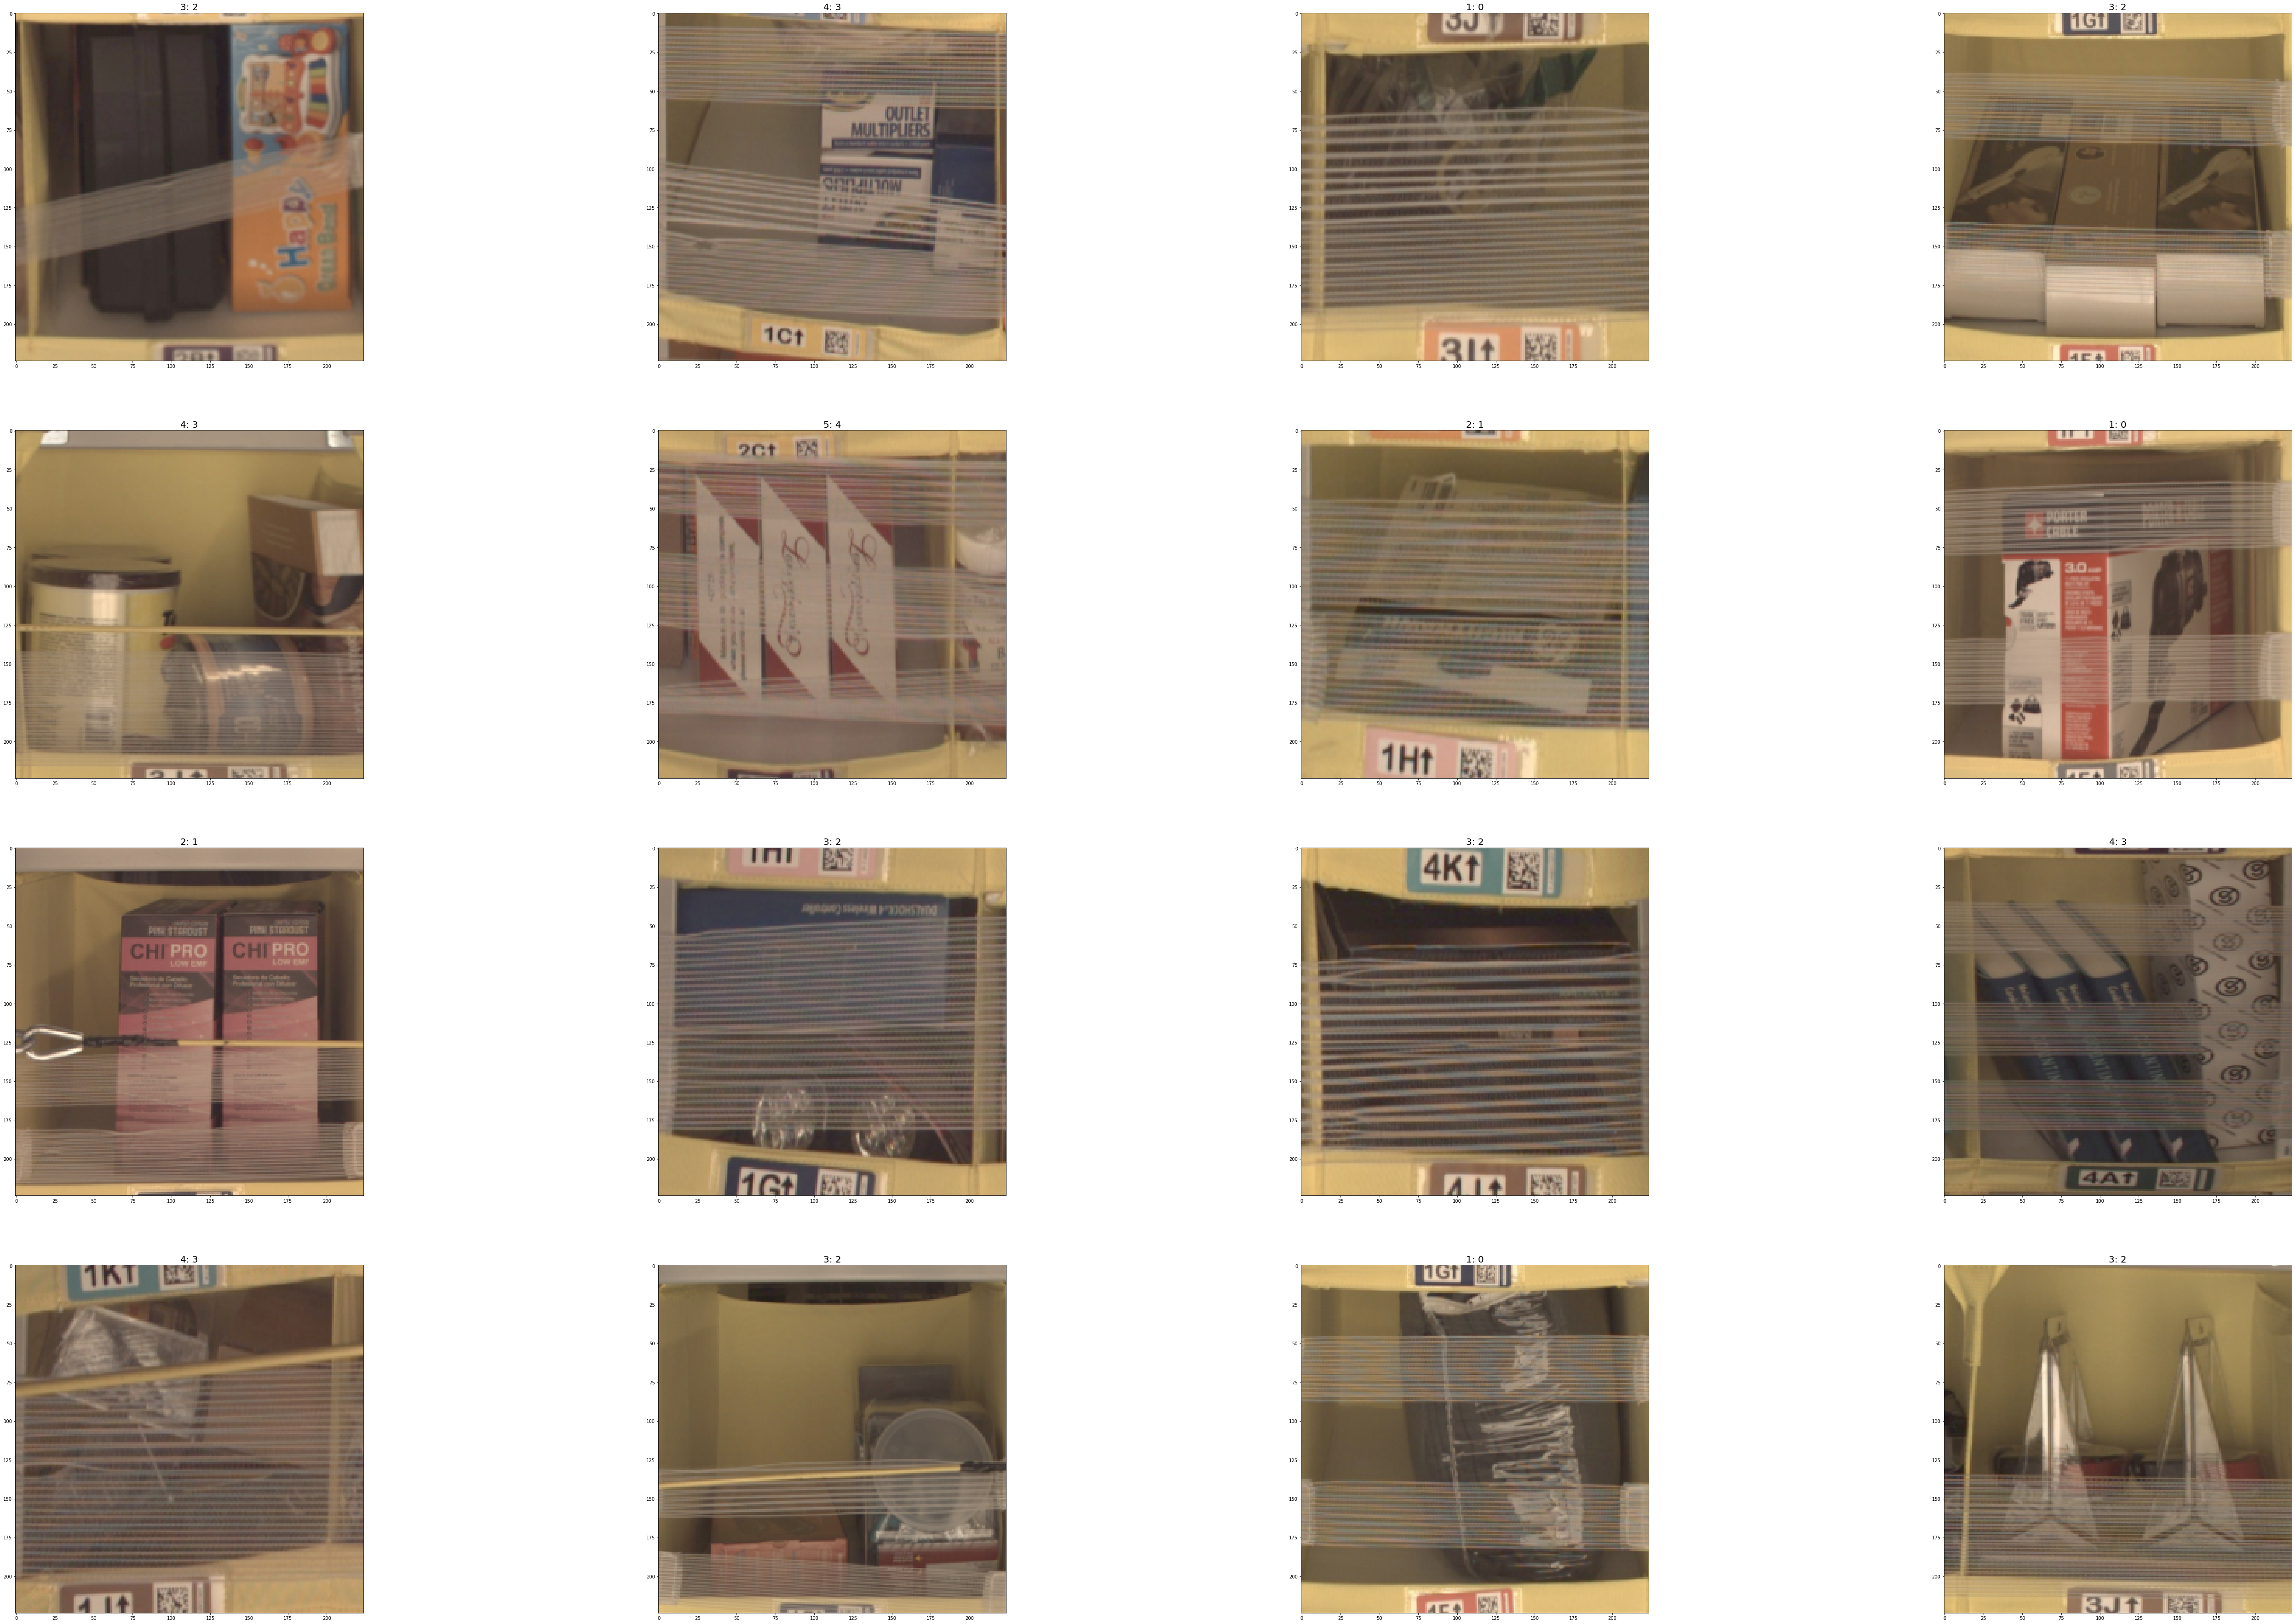

In [5]:
dataset.show_images()

In [6]:
model_list = ImagePredictor.list_models()
#model_list

We start with specifying the pretrained neural network candidates. Given such a list, AutoGluon tries to train different networks from this list to identify the best-performing candidate. This is an example of a autogluon.core.space.Categorical search space, in which there are a limited number of values to choose from.

In [21]:
models = ag.Categorical('coat_tiny', 'inception_v4', 'resnet18', 'resnet26', 'vgg16')

Similarly, we can manually specify many crucial hyper-parameters, with specific value or search space

In [22]:
batch_sizes = ag.Categorical(32, 64, 128, 256)
learning_rates = ag.Real(0.001, 0.1, log=True)

In [6]:
hyperparameters={'model': models, 'batch_size': batch_sizes, 'lr': learning_rates, 'epochs': 2}
hyperparameters={'epochs': 3}
predictor = ImagePredictor()
predictor.fit(dataset, 
              time_limit=60*120, 
              hyperparameters=hyperparameters,
              hyperparameter_tune_kwargs={'searcher': 'bayesopt'})

`time_limit=auto` set to `time_limit=7200`.
Reset labels to [0, 1, 2, 3, 4]
Randomly split train_data into train[1881]/validation[210] splits.
The number of requested GPUs is greater than the number of available GPUs.Reduce the number to 1
Starting fit without HPO
modified configs(<old> != <new>): {
root.img_cls.model   resnet101 != resnet50
root.train.epochs    200 != 2
root.train.early_stop_baseline 0.0 != -inf
root.train.early_stop_max_value 1.0 != inf
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.misc.seed       42 != 120
}
Saved config to /root/SageMaker-Inventory-monitoring/089bb29c/.trial_0/config.yaml
Model resnet50 created, param count:                                         23518277
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]


RuntimeError: DataLoader worker (pid 186) is killed by signal: Bus error. It is possible that dataloader's workers are out of shared memory. Please try to raise your shared memory limit.

In [ ]:
predictor.fit_summary()

This part was performed within a ml.m5.large instance. The use of GPU equipped instance was always throwing back the following error message:
"RuntimeError: DataLoader worker (pid 186) is killed by signal: Bus error. It is possible that dataloader's workers are out of shared memory. Please try to raise your shared memory limit." And it is impossible to increase the shared memory limit manually.

List limitations of such investigation    
-3 epochs is low, and some models can have different learning curves. In other words, we might end up selecting a model which learn fast but would have quickly converged or overfitted, and missed one which would have reach an higher accuracy given more time to train. 

-Autogluon makes use of transfer learning, therefore, the observed performance might be due to how the models have been pretrained (dataset, hyperparameters...) and not the model itself.


